# Topic 1: Finding the Ground State of a Molecule using Variational Quantum Eigensolver

Based on example from https://github.com/qiskit-community/qiskit-nature-pyscf.

## Table of contents

1. Introduction
    - Use case
    - Theory
2. VQE tutorial
    - Imports and setup
    - Flowchart summarising main steps of VQE calculation
    - Defining functions
    - Example: LiH
    - Comparing Hartree-Fock approximation to VQE output
    - Classical solution
    - Comparing quantum vs classical solutions
    - Bond stretching workflow
3. Exercise
4. Conclusions
5. References

## 1. Introduction

### 1.1 Use Case

In this notebook, we investigate the **ground-state electronic structure** of **diatomic molecules (dimers)** using a combination of classical and quantum computational methods. Specifically, we calculate the ground-state energy of several small molecules across a range of bond lengths. These calculations help us understand how the **electronic structure evolves with molecular geometry**, which is important for studying chemical bonding and molecular stability.

The goal is to compare the accuracy and performance of different approaches:
- **Hartree-Fock (HF)** as a mean-field classical approximation,
- **Full Configuration Interaction (FCI)** as an exact (but expensive) classical method,
- **Variational Quantum Eigensolver (VQE)** as a hybrid quantum-classical algorithm that is promising for near-term quantum devices.

By applying these methods to the same set of molecular systems and geometries, we aim to evaluate the **viability of quantum algorithms like VQE** for practical molecular simulations, especially in the context of bond dissociation and chemical reactivity — tasks that are known to challenge classical methods.

Accurate ground-state energy calculations are essential for predicting molecular behavior, and hybrid quantum-classical algorithms offer a potential pathway to overcome classical scaling limits in quantum chemistry.


### 1.2 Theory — Classical and Quantum Solutions

Classical computational chemistry relies on solving the electronic Schrödinger equation using approximations tailored to trade accuracy for computational tractability. Among these:

- **Hartree-Fock (HF)** is a mean-field method that approximates electron interactions in an averaged way. It is efficient but lacks correlation energy, which limits its accuracy especially for stretched bonds or strongly correlated systems.
  
- **Full Configuration Interaction (FCI)** provides an exact solution within a given basis set by considering **all possible electron configurations**. It accounts for all electron correlation effects, making it a benchmark method for small systems. However, the computational cost of FCI scales **exponentially** with the number of orbitals, making it intractable for anything but very small molecules.

Quantum computing offers a different paradigm. Instead of simulating all configurations explicitly, it uses **quantum bits (qubits)** to represent quantum states of the electronic orbitals directly. In particular, the **Variational Quantum Eigensolver (VQE)** is a hybrid algorithm well-suited for near-term quantum devices (also known as Noisy Intermediate-Scale Quantum — NISQ — devices). The VQE algorithm:

- Uses a **parameterized quantum circuit** (ansatz) to prepare a trial wavefunction.
- Measures the expectation value of the Hamiltonian with respect to this state. In this notebook, we simulate this measurement on a classical computer using Qiskit's quantum simulators, which emulate how a real quantum device would behave.
- Optimizes the circuit parameters using a **classical optimizer** to minimize the energy.

In this notebook, we implement VQE using the **Unitary Coupled Cluster with Single and Double excitations (UCCSD)** ansatz — a physically motivated approach that builds the trial wavefunction based on electronic excitations from a reference state. We use **Qiskit**, a widely adopted framework for quantum computing, to construct and simulate these quantum circuits.

By comparing the computed ground-state energies from HF, FCI, and VQE across different bond lengths, we assess the accuracy and feasibility of hybrid quantum-classical simulations for molecular electronic structure problems.

## 2. VQE tutorial

### 2.1 Imports and setup

In [1]:
from pyscf import gto, scf, mcscf, fci 
# pyscf = (classical) python-based simulations of chemistry framework
# gto.M: defines molecular geometry & basis set (Gaussian-type orbitals)
# scf.RHF: provides restricted Hartree-Fock method used as starting point for other methods
# mcscf.CASCI: complete active space configuration interaction, useful for strongly correlated systems
# fci: Full configuration interaction, an exact solution for benchmarking

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.primitives import Estimator # for evaluating expectation values
from qiskit_algorithms import VQE # our quantum-classical algorithm to approximate the ground-state energy
from qiskit_algorithms.optimizers import SLSQP # classical optimizer (Sequential Least SQuares Programming) to minimize energy
from qiskit_nature.second_q.algorithms import GroundStateEigensolver ## High-level interface for ground-state computation via quantum algorithms

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
# HartreeFock: Creates the initial state for VQE.
# UCCSD: Unitary Coupled Cluster with Single and Double excitations ansatz — a chemically motivated trial wavefunction
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper #map fermionic operators (electrons) to qubit operators
from qiskit.visualization import circuit_drawer # to show vqe circuit

from qiskit_nature_pyscf import QiskitSolver
# Allows integration between PySCF and Qiskit Nature, enabling conversion of classical molecule data to quantum Hamiltonians.

from joblib import Parallel, delayed
# for parallel vqe calculations at different bond lengths


### 2.2 Flowchart summarising main steps of VQE calculation:

```mermaid
%%{
    init: {
        'theme': 'base',
        'themeVariables': {
        'primaryColor': '#BB2528',
        'primaryTextColor': '#fff',
        'primaryBorderColor': '#7C0000',
        'lineColor': '#F8B229',
        'secondaryColor': '#006100',
        'tertiaryColor': '#fff'
        }
    }
    }%%
graph TD
subgraph Problem
direction LR;
    A((Define Molecule))
    A --> B(Select active orbitals & electrons)
end
    
subgraph Mapping
direction LR;
    C(Choose Qubit Mapping: Jordan-Wigner/Parity)
    C --> D(Select Ansatz: UCCSD, PUCCD, etc. This defines circuit structure.)
end
    Problem --> Mapping
    
subgraph Circuit
direction LR;
    E(Initialize Parameters - all zero)
    E --> F(Initial state = Hartree-Fock state)
    F --> G(Run Quantum Circuit & Measure)
end
    Mapping --> Circuit
    
    Circuit --> H(Compute Energy i.e. Expectation Value of Hamiltonian)
    H --> I{Convergence?}
    I -- No --> J(Update Parameters via Classical Optimizer) --> Circuit
    I -- Yes --> K(Return Optimized Energy & Parameters);
```

### 2.3 Defining functions

We will need functions set up to:
- Run the VQE algorithm
- Define the molecules that we want to investigate
- Extract the elements within the molecules
- Vary the bond length of the molecules
- Calculate the active orbitals and electrons

In [2]:
def run_vqe(h_f):
    """
    Prepare a quantum computing-based method to solve the electronic structure problem.

    Parameters
    ----------
    norb : int
        Number of active orbitals
    n_alpha : int
        Number of alpha (spin up) electrons
    n_beta : int
        Number of beta (spin down) electrons
    h_f : method
        Hartree-Fock method used to calculate the initial guess for the electronic structure.

    Returns
    -------
    total_energy : float
        The total energy of the system calculated by the CASCI method. This value 
        includes the electron correlation effects within a predefined active space 
        of orbitals.
    
    ansatz : UCCSD
        The quantum circuit ansatz (final version after parameter optimization) 
        used in the VQE algorithm.

    vqe : VQE
        The VQE optimizer object, which contains the optimized parameters used 
        in the ansatz.

    Notes
    -----
    The total energy (`cas.e_tot`) is computed using the Complete Active Space 
    Configuration Interaction (CASCI) method. CASCI selects a set of active 
    orbitals and performs a configuration interaction calculation to account for 
    electron correlation within the active space.

    The optimized ansatz is obtained after running the VQE algorithm, which minimizes 
    the energy of the quantum state described by the UCCSD ansatz.
    """
    nelec = n_alpha + n_beta
    
    ansatz = UCCSD( # Unitary Coupled Cluster with Single and Double excitations (trial wavefunction)
        norb,
        (n_alpha, n_beta),
        mapper,
        initial_state=HartreeFock(
            norb,
            (n_alpha, n_beta),
            mapper,
        ),
    )
    # list of predefined  ansatzes: https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.circuit.library.html
    
    vqe = VQE(Estimator(), ansatz, SLSQP()) 
    # to minimise the ground-state energy using classical Sequential Least Squares Programming optimisation
    # list of optimizers: https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html
    
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    algorithm = GroundStateEigensolver(mapper, vqe)

    cas = mcscf.CASCI(h_f, norb, nelec) # selects active orbitals and electrons
    cas.fcisolver = QiskitSolver(algorithm)
    #replaces the default FCI solver in PySCF with the VQE-based quantum solver
    
    cas.run()
    return cas.e_tot, ansatz

In [3]:
# Dictionary of dimers with atom labels and bond lengths in Angstroms
dimers = {
    "H2":   ("H", "H", 0.74),
    "LIH":  ("Li", "H", 1.6),
    "CO":   ("C", "O", 1.13),
    "N2":   ("N", "N", 1.1),
    "O2":   ("O", "O", 1.21),
}

def create_dimer(name, bond_length=None, basis='sto-3g'):
    """
    Create a diatomic molecule. If bond_length is provided, use it;
    otherwise, use the default from the dimers dictionary.
    """
    try:
        A, B, default_bond_length = dimers[name.upper()]  # Normalize to uppercase
    except KeyError:
        raise ValueError(f"Molecule '{name}' not found in dimers dictionary.")

    bond_length = bond_length if bond_length is not None else default_bond_length

    mol = gto.Mole()
    mol.atom = [
        [A, (0.0, 0.0, 0.0)],
        [B, (0.0, 0.0, bond_length)],
    ]
    mol.basis = basis
    mol.build()
    return mol

In [4]:
def get_elements(molecule):
    """
    Returns a list of element symbols (e.g., ['Li', 'H']) from a PySCF Mole object.
    """
    return [atom[0] for atom in molecule._atom]

In [5]:
def number_of_orbitals(molecule):
    """
    Returns the number of spatial orbitals a given molecule has for a given basis, assuming a full active space
    """
    basis_sets = ["sto-3g", "3-21G", "6-31g", "cc-pVDZ"]
    basis_dict = {'H': [1, 2, 2, 5], 'He': [1, 2, 2, 5],
                  'Li': [5, 9, 9, 14], 'Be': [5, 9, 9, 14], 'B': [5, 9, 9, 14],
                  'C': [5, 9, 9, 14], 'N': [5, 9, 9, 14], 'O': [5, 9, 9, 14], 'F': [5, 9, 9, 14]}
    if molecule.basis in basis_sets:
        index = basis_sets.index(molecule.basis)
    else:
        raise Exception("Basis '{}' not recognized".format(molecule.basis))

    n_orbitals = 0
    for element in get_elements(molecule):
        if element not in basis_dict.keys():
            raise Exception("Element '%s' not supported. Currently only elements H-Mg are supported." % element)
        else:
            n_orbitals += basis_dict[element][index]
    return n_orbitals

In [6]:
def get_frozen_core_active_orbitals(molecule):
    """
    Computes the frozen core active space:
    - Returns list of active orbitals
    - Number of active orbitals
    - Number of alpha (spin up) and beta (spin down) electrons in the valence shell
    
    Assumptions:
    - Closed-shell molecules (default balanced alpha/beta spins)
    - Currently supports elements H–F
    
    References:
    - This function is based on part of the code from the QPFAS library developed by ICHEC
    - https://github.com/ICHEC/QPFAS/blob/0.4.0-beta/py/qpfas/chemistry/active_space.py
    - (QPFAS is used for simulating PFAS molecules via quantum computing)
    """

    # Frozen core orbital count per element (e.g., 1s core)
    el_dict = {'H': 0, 'He': 0, 'Li': 1, 'Be': 0,
               'B': 1, 'C': 1, 'N': 1, 'O': 1, 'F': 1}

    # Atomic numbers (Z)
    atomic_numbers = {
        'H': 1, 'He': 2, 'Li': 3, 'Be': 4,
        'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9
    }

    elements = get_elements(molecule)

    # Total number of electrons
    total_electrons = sum(atomic_numbers[el] for el in elements)

    # Number of frozen orbitals and electrons
    num_frozen_orbitals = sum(el_dict[el] for el in elements)
    frozen_electrons = 2 * num_frozen_orbitals

    # Active electrons
    valence_electrons = total_electrons - frozen_electrons

    # Distribute equally for closed shell (can be made flexible later)
    num_alpha = valence_electrons // 2
    num_beta  = valence_electrons // 2

    # Active orbitals (each orbital holds 2 electrons)
    n_orbitals = number_of_orbitals(molecule)
    active_orbitals = list(range(num_frozen_orbitals, n_orbitals))

    return {
        "active_orbitals": active_orbitals,
        "num_active_orbitals": int(len(active_orbitals)),
        "num_alpha": num_alpha,
        "num_beta": num_beta
    }


### 2.4 Example: LiH

We now use the algorithm defined above to calculate the ground state energy of LiH.

In [7]:
# Defining the LiH molecule created with STO-3G basis set
mol = create_dimer("LiH")
print(mol._atom)
get_elements(mol)
# NB positions will be in Bohr radii (PySCF internally converts to Bohr radii upon building the molecule)
# conversion: 1 Angstrom = 1.88973 Bohr radii

[('Li', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 3.0235617993040993])]


['Li', 'H']

Select the active orbitals to simulate:
- Electronic structures of lithium and hydrogen are as follows
    - Li: $1s^22s^12p^0$
    - H:  $1s^1$

* The inner 1s orbital of Li is frozen, i.e. these two electrons are paired as $\ket{\uparrow\downarrow}$. We do not include these in the simulation, to reduce the number of qubits required.
* For the five spatial orbitals that we are including in our simulation ($1\times$ Li 2s, $3\times$  Li 2p and $1\times$ H 1s) we need two qubits each, one to represent occupied/unoccupied and one to encode spin up/down
* In total: 5 active orbitals * 2 qubits each = 10 qubits

* We have two valence electrons, one from the outer shell of the lithium atom and one from hydrogen atom
* We assume that these are split evenly between spin up and down, i.e. one alpha and one beta electron

Let's see if the functions we defined above give us the same values for these constants as we expect from this reasoning:

In [8]:
# Extract constants
frozen_core_result = get_frozen_core_active_orbitals(mol)

# which are the active orbitals:
active_orb = frozen_core_result["active_orbitals"]

# number of active orbitals:
norb = int(frozen_core_result["num_active_orbitals"])

# number of alpha (spin up) electrons
n_alpha = frozen_core_result["num_alpha"]

# number of beta (spin down) electrons
n_beta = frozen_core_result["num_beta"]

print('number of active orbitals =',norb)
print('number of alpha electrons =',n_alpha)
print('number of beta electrons =',n_beta)

number of active orbitals = 5
number of alpha electrons = 1
number of beta electrons = 1


We import two mappers, giving us two different ways to convert the electronic structure of a molecule from a fermionic problem to a qubit problem.
1. Jordan-Wigner Mapper: Simple, intuitive
    - 1 spin orbital $\rightarrow$ 1 qubit
    - unoccupied $\rightarrow\ket{0}$; occupied $\rightarrow\ket{1}$
    - spin down $\rightarrow\ket{0}$; spin up $\rightarrow\ket{1}$

2. Parity Mapper: Can reduce number of qubits required in certain cases
    - the Parity Mapper transforms the problem into global parity information instead of directly encoding individual occupation numbers
    - each qubit stores the total parity of all previous orbitals.



In [9]:
# choose mapper
mapper = JordanWignerMapper()
#mapper = ParityMapper(num_particles=(n_alpha, n_beta))

In [10]:
# runs Restricted Hartree-Fock to get molecular orbitals and reference (HF) energy (from mean-field approx)
h_f = scf.RHF(mol).run()
energy_hf = h_f.e_tot

converged SCF energy = -7.86186476980865


In [11]:
energy_vqe, ansatz = run_vqe(h_f)

/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_34101/661902654.py:55: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe = VQE(Estimator(), ansatz, SLSQP())


CASCI E = -7.88209648916745  E(CI) = -1.07808419086540


### 2.5 Comparing Hartree-Fock approximation to VQE output

Converged SCF energy = Hartree-Fock energy, in Hartrees, from mean-field approximation, ignoring electron correlation.

- CASCI E = Complete Active Space Configuration Interaction (CASCI) energy.
- CASCI improves upon HF by allowing a full CI expansion within the active space (selected orbitals/electrons).
- Since CASCI includes static correlation effects, it should always be lower (more negative) than the SCF energy.

In [12]:
ansatz.decompose(reps=2).draw(output="mpl", fold=100, idle_wires=False)

Points to note:
- number of qubits $q_i$ (number of wires)= 2 * (number of orbitals)
- basic gates: CNOT (entangling), Pauli (X, i.e. bit-flip), parameterised rotations R_Z(t[j])
- t[j] are the VQE parameters that are optimised during the algorithm


### 2.6 Classical Solution
We want to compare our solution from the quantum algorithm (VQE) with the best classical solution. FCI (Full Configuration Interaction) provides a numerically exact solution for the ground state by solving the electronic Schrödinger equation. This is acheieved by fully diagonalizing the Hamiltonian in the complete active space of Slater determinants. This approach however is very computationally expensive — scaling exponentially with the system size. FCI is only possible for small single atoms or very small molecules with ~12 electrons or fewer.

In [13]:
def run_fci(h_f):
    """run a fci calculation for a benchmark"""
    cisolver = fci.FCI(h_f)
    cisolver = cisolver.run()
    return cisolver.e_tot

In [14]:
energy_fci = run_fci(h_f)

### 2.7 Comparing quantum vs classical solutions

In [15]:
print("VQE Energy:", energy_vqe) #quantum
print("FCI Energy:", energy_fci) #classical

VQE Energy: -7.882096489167447
FCI Energy: -7.882324378883491


### 2.8 Bond stretching workflow

In [16]:
bond_lengths = np.linspace(1.4, 1.7, 5) # range and number of bond lengths

# defining a function to calculate the energy at different bond lengths, via HF, FCI and VQE
def get_vqe_results(bond_length):
    stretchmol = create_dimer("LiH", bond_length)
    h_f = scf.RHF(stretchmol).run()
    energy_vqe, ansatz = run_vqe(h_f)
    energy_fci = run_fci(h_f)
    return h_f.e_tot, energy_vqe, energy_fci

# running the calculations for each bond length in parallel
results = Parallel(n_jobs=-1)(
    delayed(get_vqe_results)(bl) for bl in bond_lengths
)

h_f_energies, vqe_energies, fci_energies = zip(*results)


converged SCF energy = -7.86053866102113
converged SCF energy = -7.85714496020382
converged SCF energy = -7.86310660055546
converged SCF energy = -7.86095140747504
converged SCF energy = -7.86307516130408


/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_34101/661902654.py:55: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_34101/661902654.py:55: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
/var/folders/x9/wfb287qn00v442vdfjd74t680000gq/T/ipykernel_34101/661902654.py:55: DeprecationWarning: The class ``qiskit.primi

CASCI E = -7.87919778047936  E(CI) = -1.05567495805786
CASCI E = -7.87823057515856  E(CI) = -1.12139025743433
CASCI E = -7.88253652978938  E(CI) = -1.08920713453584
CASCI E = -7.88158301294217  E(CI) = -1.10560110013292
CASCI E = -7.88160301186137  E(CI) = -1.07249120399332


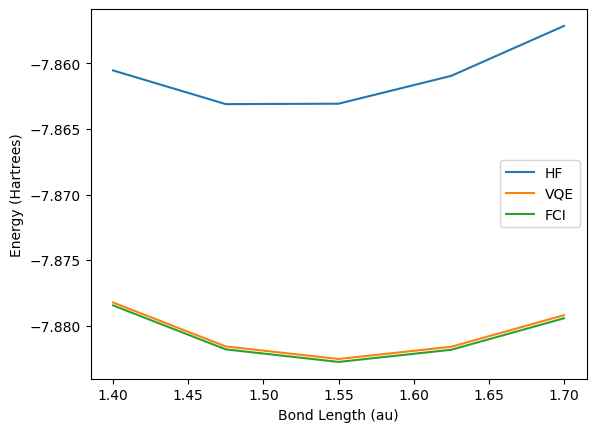

In [18]:
plt.plot(bond_lengths, h_f_energies, label="HF")
plt.plot(bond_lengths, vqe_energies, label="VQE")
plt.plot(bond_lengths, fci_energies, label="FCI")
plt.xlabel("Bond Length (au)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

## 3. Exercise

#### 3.1 Change molecule
- Make a copy of the code and try a different molecule.
- I.e. replace `LiH` in `mol = create_dimer("LiH")` with one of the other molecules from the `dimers` dictionary.
- How many qubits are required now?
- Depending on the problem size you may wish to increase the number of points in the energy vs bond length plot to achieve a smoother curve.
#### 3.2 Change mapping:
 Try the parity mapper instead of the Jordan-Wigner mapper and investigate effect on results.
- Is the qubit count reduced?
- Is the run time reduced?
- What about the accuracy in comparison with FCI?

## 4. Conclusions

In this notebook, we explored the **ground-state electronic structure of diatomic molecules** using a combination of classical and quantum computational techniques. We implemented a workflow that:

- Constructed molecular systems from a simple dictionary of dimers and their bond lengths.
- Computed reference energies using **Hartree-Fock (HF)** and **Full Configuration Interaction (FCI)**, providing a classical baseline.
- Applied the **Variational Quantum Eigensolver (VQE)** algorithm using the **UCCSD ansatz** to approximate the ground-state energy via a hybrid quantum-classical approach.
- Reproduced the expected **energy vs. bond length curve**, validating the simulation and showcasing the physical behavior of bond formation and dissociation.

By comparing results across bond distances, we observed that:
- HF gives a quick but approximate result, failing to capture electron correlation.
- FCI provides the most accurate solution within a given basis set, but becomes intractable for systems beyond a few electrons or orbitals.
- VQE approximates the FCI solution well in many cases and may offer a more scalable path forward for studying electronic structure using quantum resources.

While the VQE results were obtained using a **classical quantum simulator**, the structure of the workflow mirrors what would be used on real NISQ hardware.

#### Limitations and Outlook

- Our implementation is limited to small molecules due to the scaling of FCI and the qubit requirements of VQE.
- Current simulations assume **no noise**, which does not reflect today's real quantum hardware performance.
- Scaling to larger molecules will require hardware-efficient ansätze, error mitigation, and potentially other qubit mappings.

Nevertheless, this notebook demonstrates how hybrid quantum-classical methods can be used today to **reproduce chemically meaningful results** and benchmark against trusted classical methods. As quantum technology advances, the approach outlined here will form the basis for more complex and realistic quantum chemistry calculations — particularly in cases where classical methods struggle.

## 5. References
- ICHEC QPFAS repository
    - https://www.ichec.ie/qpfas
- Hartree-Fock approximation
    - Sherrill, C. David. "An introduction to Hartree-Fock molecular orbital theory." School of Chemistry and Biochemistry Georgia Institute of Technology https://vergil.chemistry.gatech.edu/static/content/hf-intro.pdf (2000).
    - Szabo, A., & Ostlund, N. S. (2012). *Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory*. Courier Corporation.
- Full Configuration Interaction
    - https://vergil.chemistry.gatech.edu/static/content/ci.pdf
    - Helgaker, Trygve, Poul Jorgensen, and Jeppe Olsen. Molecular electronic-structure theory. John Wiley & Sons (2013).
- VQE
    - https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver
    - Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 https://www.nature.com/articles/ncomms5213 (2014).

## Acknowledgements

We extend our gratitude to the Irish Centre for High-End Computing (ICHEC) and University of Galway for providing computing and for all-encompassing invaluable support. This project was funded by the EuroHPC JU under grant agreement No 951732 and Ireland.

<div>
  <img src="../logos/logos.png" height="100">
</div>